# <center>Масштабирование признаков

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import QuantileTransformer


## Standard Scaler

In [2]:
data = pd.read_excel('data/data_ford_price.xlsx')[['price', 'year', 'weather']]
data.dropna(inplace=True)
data_scaled = data.copy()
col_names = ['price', 'weather']
x = data_scaled[col_names]

scaler = StandardScaler()
 
data_scaled[col_names] = scaler.fit_transform(x.values)
data_scaled.head()

,price,year,weather
0,2.558728,2016,0.862068
1,0.067373,2009,-0.017965
2,-1.072197,2002,-0.897998
3,-1.176990,2000,-0.395122
5,-0.677579,2003,-0.269403


In [4]:
y = data_scaled['year']
x = data_scaled.drop(columns='year')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)
 
model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 3.041


## Robust Scaler

In [9]:
rb_scaler = RobustScaler()
rb_scaled_price = rb_scaler.fit_transform(data[['price']])
data['price'] = rb_scaled_price
data['price'][1]

0.1894603976017671

## Quantile Transformer
>**Квантильное преобразование** сопоставляет распределение вероятностей переменной с другим распределением вероятностей с использованием квантильной функции.
>
>**Квантильная функция**, также называемая **функцией процентной точки (PPF)**, является обратной функцией кумулятивного распределения вероятностей (CDF).
>
>**CDF** — это функция, которая возвращает вероятность значения, равного или меньше заданного значения.

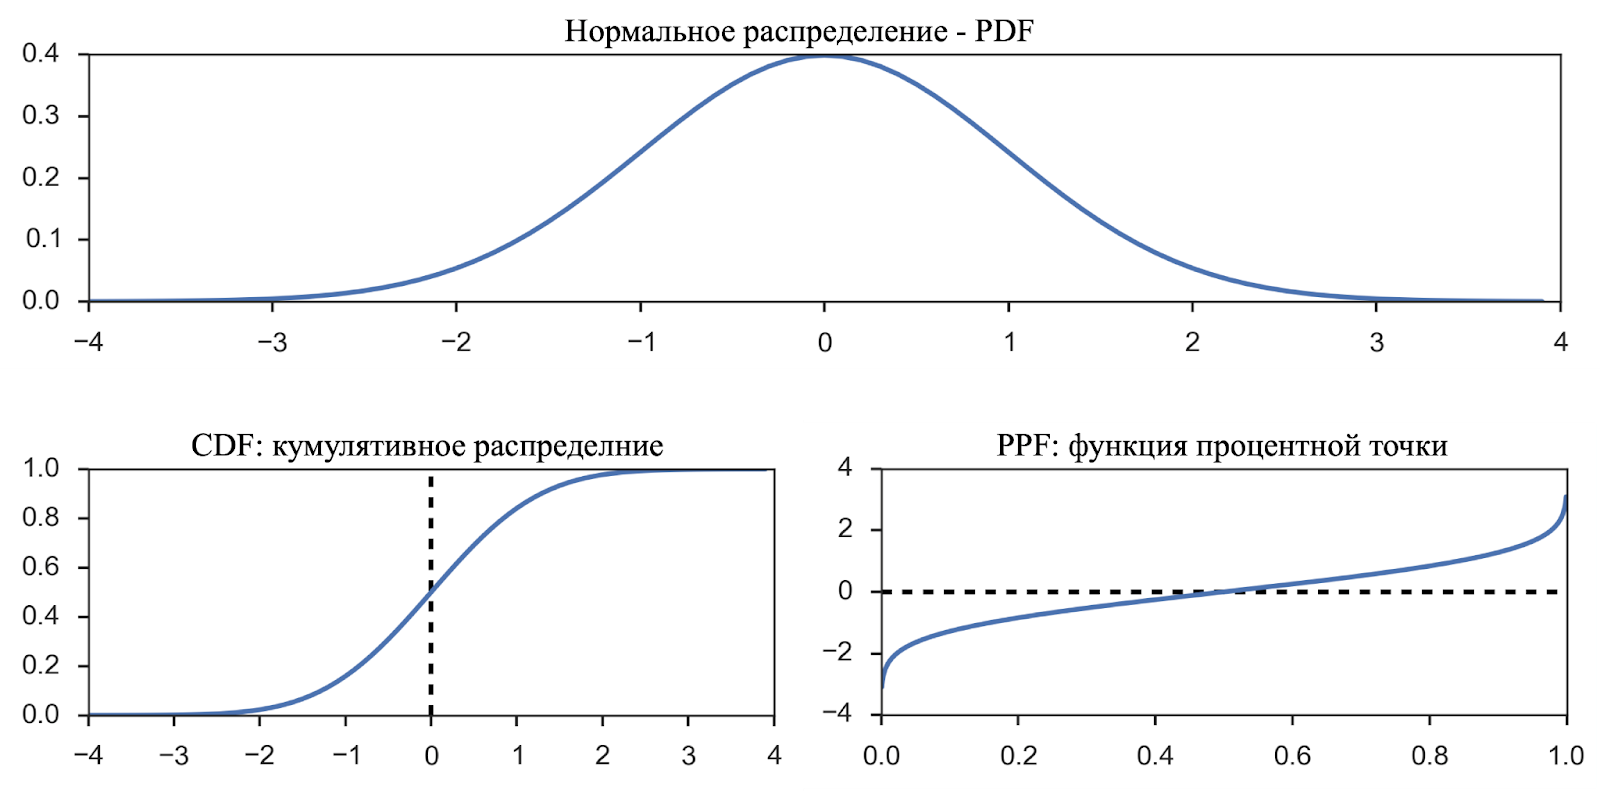

`sklearn.preprocessing.QuantileTransformer`

У класса есть аргумент `output_distribution`, который может принимать значение `'uniform'` или `'normal'` (по умолчанию — `'uniform'`).

Гиперпараметр `n_quantiles` определяет разрешение отображения или ранжирование наблюдений в наборе данных. Это значение должно быть меньше, чем количество наблюдений в наборе данных, и по умолчанию равно `1000`.

<font color=lightpink>Поскольку этот метод изменяет само распределение переменных, из-за этого скейлера линейные отношения между переменными могут быть разрушены. Таким образом, лучше всего использовать его для нелинейных данных.</font>

<AxesSubplot: >

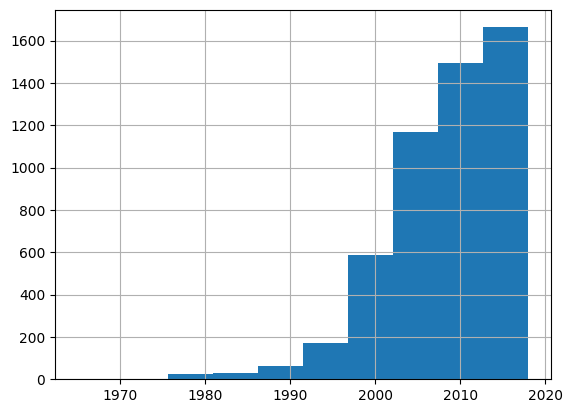

In [16]:
data = pd.read_excel('data/data_ford_price.xlsx')
data.dropna(inplace=True)
data['year'].hist()

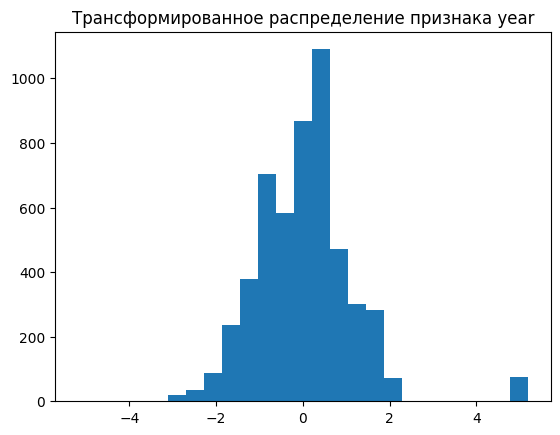

In [18]:
# Данный трансформер принимает на вход 2D-массив, поэтому нам надо изменить формат данных (поскольку что мы подаём на вход только один столбец)
data_for_transform = data[['year']]
 
quantile = QuantileTransformer(output_distribution='normal')
data_transformed = quantile.fit_transform(data_for_transform)
 
plt.hist(data_transformed, bins=25)
plt.title('Трансформированное распределение признака year')
plt.show()

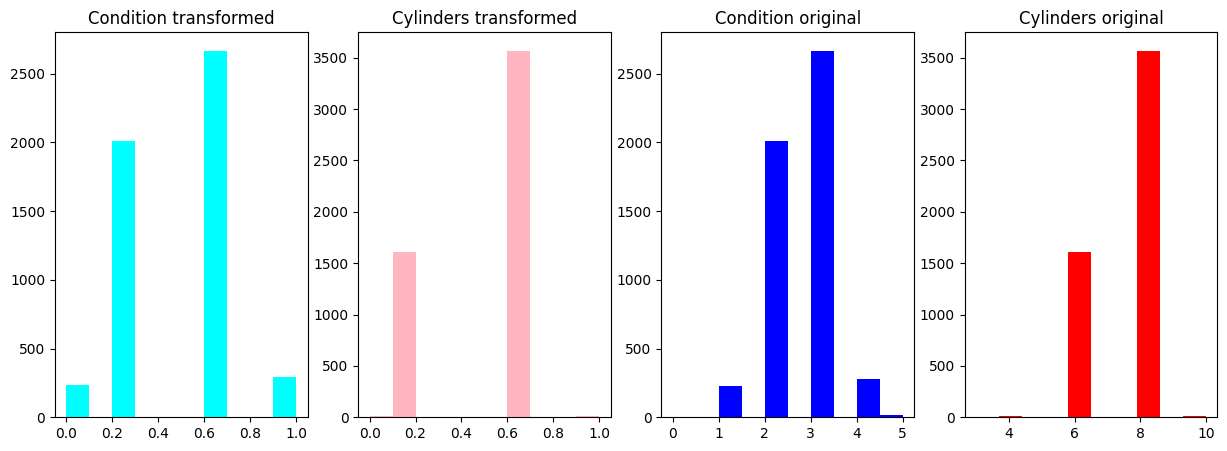

In [52]:
data_for_transform = data[['condition', 'cylinders']]
quantile_transformer = QuantileTransformer(output_distribution='uniform')
data_transformed = quantile_transformer.fit_transform(data_for_transform)
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].hist(data_transformed[:, 0], color='cyan')
axes[1].hist(data_transformed[:, 1], color='lightpink')
axes[0].set_title('Condition transformed')
axes[1].set_title('Cylinders transformed')
axes[2].hist(data['condition'], color='blue')
axes[3].hist(data['cylinders'], color='red')
axes[2].set_title('Condition original')
axes[3].set_title('Cylinders original');

In [49]:
data_transformed[:5]

array([[0.97097097, 0.15665666],
       [0.23773774, 0.65465465],
       [0.23773774, 0.65465465],
       [0.02252252, 0.65465465],
       [0.68818819, 0.65465465]])

## Log Transform
>**Логарифмическое преобразование** — один из самых популярных методов преобразования. В основном оно используется для превращения асимметричного распределения в нормальное/менее асимметричное. В этом преобразовании мы берём логарифм значений признака вместо самих значений.

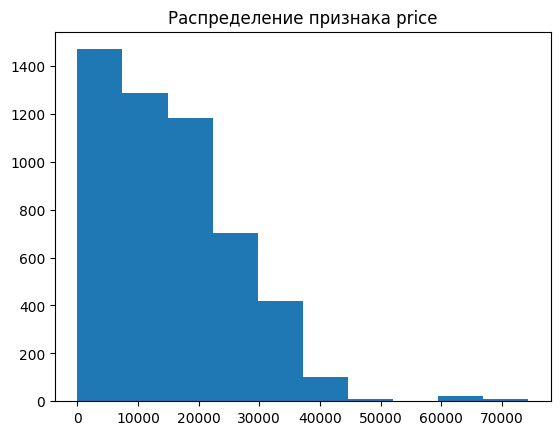

In [53]:
plt.hist(data.price)
plt.title('Распределение признака price');

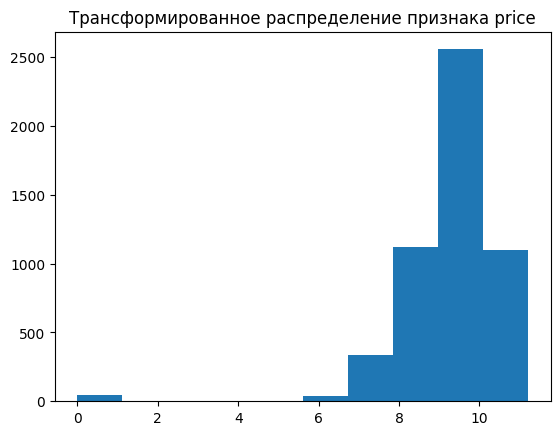

In [55]:
log_price = np.log(data['price'])
 
plt.hist(log_price)
plt.title('Трансформированное распределение признака price')
plt.show()

In [56]:
price_data = pd.concat([data['price'], log_price.rename('transformed_price')], axis = 1)
 
price_data.describe()

,price,transformed_price
count,5202.000000,5202.000000
mean,15388.826797,9.254334
std,10820.253885,1.264931
min,1.000000,0.000000
25%,6800.000000,8.824678
50%,13880.000000,9.538204
75%,21995.000000,9.998570
max,74374.000000,11.216862


>Стоит учесть, что, если наши данные имеют отрицательные значения или значения в диапазоне от 0 до 1, мы не можем применить логарифмическое преобразование напрямую, поскольку логарифм отрицательных чисел и 0 не определён, то есть мы получим ошибки или значения NaN в наших данных. В таких случаях мы можем добавить число к этим значениям, чтобы все они были больше 1.

In [59]:
log_price.tail(3)

7013    8.695339
7015    9.296518
7016    9.798127
Name: price, dtype: float64

## Power transformer scaler
Power Transformer фактически автоматизирует принятие этого решения, вводя параметр, называемый `lambda`. Он принимает решение об обобщённом степенном преобразовании, находя наилучшее значение `lambda`, используя один из следующих параметрических методов:

* **Преобразование Бокса-Кокса**, которое работает для положительных значений признака.
* **Преобразование Йео-Джонсона**, которое учитывает при расчётах нулевые и отрицательные значения обрабатываемых переменных.


C:\Users\sadeyes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_morestats.py:922: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
C:\Users\sadeyes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\sadeyes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


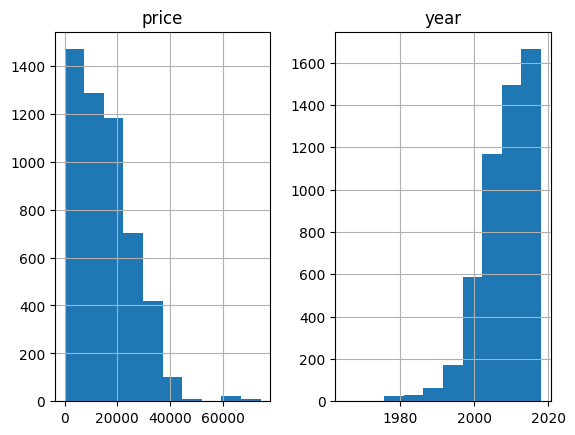

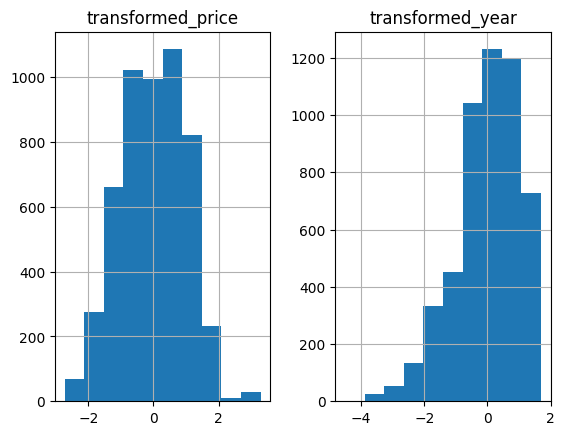

In [62]:
box_cox = PowerTransformer(method='box-cox')
 
data_box_cox = box_cox.fit_transform(data[['price', 'year']])
data_box_cox = pd.DataFrame(data_box_cox, columns=['transformed_price', 'transformed_year'])
data[['price', 'year']].hist()
data_box_cox.hist();